# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Download and Load The Data

In [4]:
import cv2
import datetime
import numpy as np
import os
import sys
import shutil
from sklearn.utils import shuffle
from six.moves.urllib.request import urlretrieve
from six.moves.urllib.parse import urlsplit
import tensorflow as tf
import time
import zipfile

In [5]:
DATA_URL = "https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581faac4_traffic-signs-data/traffic-signs-data.zip"

last_percent_reported = None
def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent

def maybe_download(file_url, outdir, force=False):
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    filename = file_url.split('/')[-1]
    outfile = os.path.join(outdir, filename)
    
    if force or not os.path.exists(outfile):
        print("Downloading file from %s" % file_url)
        filename, _ = urlretrieve(file_url, outfile, reporthook=download_progress_hook)
        print("Completed download in %s" % filename)
    else:
        print("File already exists")
        
    print("File size %d mb" % (os.path.getsize(outfile) >> 20))
    return outfile

In [6]:
filename = maybe_download(DATA_URL, "data")
if not os.path.exists("data/train.p"):
    print("unzipping the file")
    zip_ref = zipfile.ZipFile(filename, 'r')
    zip_ref.extractall("data")
    zip_ref.close()

File already exists
File size 115 mb


---
## Step 0: Load The Data

In [7]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "data/train.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [8]:
### Replace each question mark with the appropriate value.
print(X_train.dtype, X_train.shape, y_train.dtype, y_train.shape, )

# TODO: Number of training examples
n_train = y_train.shape[0]

# TODO: Number of testing examples.
n_test = y_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = y_train.max() + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

uint8 (39209, 32, 32, 3) uint8 (39209,)
Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [9]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
import random

In [76]:
# load the acual labes from signnames.csv
import csv

label_signs = dict()
label_file = "signnames.csv"

with open(label_file) as f:
    reader = csv.reader(f)
    header = next(reader)
    label_signs = dict((int(row[0]), row[1]) for row in reader)

33815
label id=34. label text='Turn left ahead'


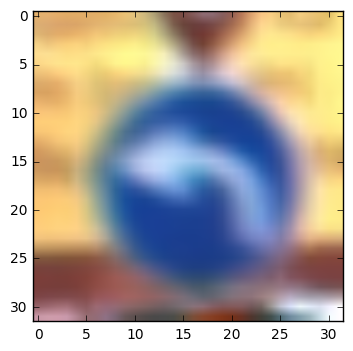

In [12]:
rand_idx = random.randint(0, n_train - 1)
print(rand_idx)
label = y_train[rand_idx]
print("label id={0}. label text='{1}'".format(label, label_signs[label]))
plt.imshow(X_train[rand_idx, :, :, :])

Sign:  Slippery road


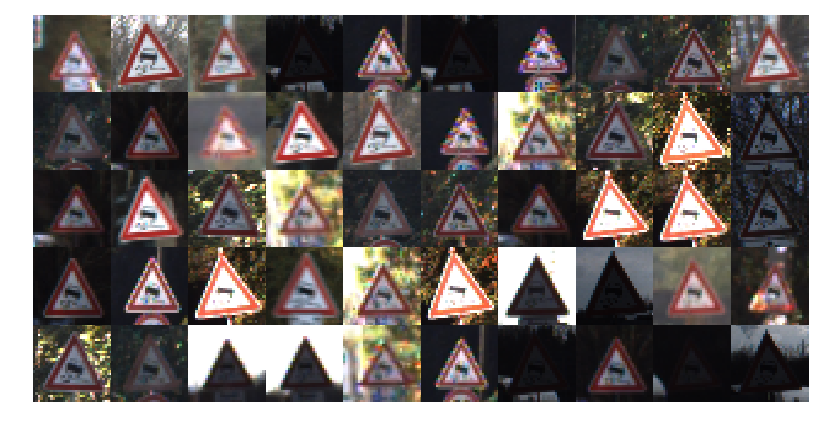

In [77]:
# Visualize few images from the same class
import matplotlib.gridspec as gridspec

num_rows = 5
num_cols = 10

fig = plt.figure(figsize=(num_cols, num_rows))
gs = gridspec.GridSpec(num_rows, num_cols, wspace=0.0, hspace=0.0)

ax = [plt.subplot(gs[i]) for i in range(num_rows * num_cols)]

#randomly select a label sign
rand_idx = random.randint(0, len(label_signs) - 1)
print("Sign: ", label_signs[rand_idx])

label_indices = y_train == rand_idx
rand_indices = np.random.randint(0, X_train[label_indices, ].shape[0],
                                 size = num_rows * num_cols)

for i, im in enumerate(X_train[label_indices, ][rand_indices, ]):
    ax[i].axis('off')
    ax[i].imshow(im, interpolation='nearest')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [14]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

### Following preprocessing steps had been done on the data
1. Split the train data into train and validation set. We do 90% and 10% split

In [15]:
# split the data into train/validation set
np.random.seed(10)

# copy the original data as we will resue the variable names X_train/y_train
X_train, y_train = train['features'], train['labels']

shuffle_indices = np.random.permutation(np.arange(y_train.shape[0]))
y_shuffled = y_train[shuffle_indices]
X_shuffled = X_train[shuffle_indices, ]

train_size = int(0.9 * y_train.shape[0])
y_train, y_validation = y_shuffled[:train_size, ], y_shuffled[train_size:, ]
X_train, X_validation = X_shuffled[:train_size, ], X_shuffled[train_size:, ]

print("Size of data, train={0} validation={1}".format(y_train.shape[0], y_validation.shape[0]))

Size of data, train=35288 validation=3921


In [16]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

#### How the training, validation and testting data is setup?
- testing data is provided
- training data is splitted into 90% training and 10% validation data
- The distribution train, validation and test data are as follows
  - Test = 12630
  - Train = 35288
  - Validation = 3921

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

### Using the LeNet-5 Neural Network Architecture

#### Input

The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. In our case C=3 as we have RGB color channels

#### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** relu activation function.

**Pooling.** The output shape should be 14x14x6.


**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using tf.contrib.layers.flatten, which is already imported for you.

**Layer 3:** Fully Connected. This should have 120 outputs.

**Activation.** relu activation function.


**Layer 4:** Fully Connected. This should have 84 outputs.

**Activation.** relu activation function.

**Layer 5:** Fully Connected (Logits). This should have 43 outputs.

**Output**
Return the result of the 2nd fully connected layer.

In [17]:
### Define your architecture here.
from tensorflow.contrib.layers import flatten

def LeNet(x, keep_prob):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # mean image subtraction
    x = x - tf.reduce_mean(x, axis=(1,2), keep_dims=True)
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    fc1_drop = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1_drop, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    fc2_drop = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2_drop, fc3_W) + fc3_b
    
    return logits

In [19]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3), name="x")
y = tf.placeholder(tf.int32, (None), name="y")
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Training Pipeline

In [20]:
rate = 0.001

logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)

global_step = tf.Variable(0)
learning_rate = tf.train.exponential_decay(rate, global_step, 5000, 0.9)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation, global_step=global_step)

### Model Evaluation

In [21]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    batch_size = 128
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train the Model

In [25]:
# create an output directory to store the model, tensorflow summary etc
def create_outdirs(root_dir):
    out_dir = os.path.join("runs", root_dir)
    print("Output directory", out_dir)

    summary_dir = os.path.join(out_dir, "summary")
    if os.path.exists(summary_dir):
        shutil.rmtree(summary_dir)
        
    checkpoint_dir = os.path.join(out_dir, "checkpoint")
    checkpoint_prefix = os.path.join(checkpoint_dir, "lenet")

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    return summary_dir, checkpoint_dir, checkpoint_prefix

In [28]:
EPOCHS = 120
BATCH_SIZE = 128

def train(X_train, y_train, summary_dir, checkpoint_prefix, epochs=EPOCHS):
    dropout_kp = .75
    
    start_time = time.time()
    with tf.Session() as sess:
        writer = tf.summary.FileWriter(summary_dir, sess.graph)
    
        sess.run(tf.global_variables_initializer())
        num_examples = X_train.shape[0]
    
        print("Training for %d" % num_examples)
        for i in range(epochs):
            X_train, y_train = shuffle(X_train, y_train)

            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,
                                                        keep_prob: dropout_kp})
            
            validation_accuracy = evaluate(X_validation, y_validation)
            print("EPOCH {} Learning Rate={:.5f} Validation Accuracy = {:.3f}".format(
                i+1, learning_rate.eval(), validation_accuracy))
        
            summary = tf.Summary()
            summary.value.add(tag="Validation Accuracy", simple_value=validation_accuracy)
            writer.add_summary(summary, i)
            writer.flush()
        
        path = saver.save(sess, checkpoint_prefix)
        print("Model saved to {0}".format(path))

    train_time = time.time() - start_time
    print("Training Time %s" % str(datetime.timedelta(seconds=train_time)))

In [33]:
summary_dir, checkpoint_dir, checkpoint_prefix = create_outdirs("baseline")
train(X_train, y_train, summary_dir, checkpoint_prefix)

Output directory runs/baseline
Training for 35288
EPOCH 1 Learning Rate=0.00099 Validation Accuracy = 0.500
EPOCH 2 Learning Rate=0.00099 Validation Accuracy = 0.715
EPOCH 3 Learning Rate=0.00098 Validation Accuracy = 0.848
EPOCH 4 Learning Rate=0.00098 Validation Accuracy = 0.898
EPOCH 5 Learning Rate=0.00097 Validation Accuracy = 0.915
EPOCH 6 Learning Rate=0.00097 Validation Accuracy = 0.939
EPOCH 7 Learning Rate=0.00096 Validation Accuracy = 0.947
EPOCH 8 Learning Rate=0.00095 Validation Accuracy = 0.952
EPOCH 9 Learning Rate=0.00095 Validation Accuracy = 0.960
EPOCH 10 Learning Rate=0.00094 Validation Accuracy = 0.966
EPOCH 11 Learning Rate=0.00094 Validation Accuracy = 0.966
EPOCH 12 Learning Rate=0.00093 Validation Accuracy = 0.963
EPOCH 13 Learning Rate=0.00093 Validation Accuracy = 0.972
EPOCH 14 Learning Rate=0.00092 Validation Accuracy = 0.968
EPOCH 15 Learning Rate=0.00092 Validation Accuracy = 0.977
EPOCH 16 Learning Rate=0.00091 Validation Accuracy = 0.978
EPOCH 17 Learni

### Evaluate the model

In [34]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir))    
    test_accuracy = evaluate(X_test, y_test)
    corrects = sess.run(correct_prediction, 
                        feed_dict={x:X_test, y:y_test, keep_prob:1.0})

    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.949


### Print accuracy by class

In [35]:
cls_names = [label_signs[i] for i in range(len(label_signs))]
train_cls_size = np.bincount(y_train) / train_size
test_cls_size = np.bincount(y_test) / y_test.shape[0]
cls_accuracy = np.bincount(y_test[corrects]) / np.bincount(y_test)
cls_result = zip(cls_names, np.bincount(y_train), train_cls_size, 
                 test_cls_size, cls_accuracy)
cls_result = sorted(cls_result, key=lambda x: x[4])
print("\t".join(["size", "train%", "test%", "accuracy", "name"]))
for c in cls_result:
    print("\t".join([str(c[1])] + ["{:.2f}".format(100.0 * e) for e in c[2:]] + [c[0]]))

size	train%	test%	accuracy	name
216	0.61	0.48	63.33	Pedestrians
301	0.85	0.71	71.11	Double curve
378	1.07	1.19	80.00	End of speed limit (80km/h)
391	1.11	1.19	80.67	Beware of ice/snow
325	0.92	0.71	81.11	Roundabout mandatory
534	1.51	1.43	85.56	Traffic signals
217	0.61	0.71	85.56	End of no passing by vehicles over 3.5 metric tons
1292	3.66	3.56	88.00	Speed limit (100km/h)
1079	3.06	3.09	88.21	General caution
200	0.57	0.48	90.00	Speed limit (20km/h)
470	1.33	1.19	90.67	Children crossing
1262	3.58	3.56	92.22	Speed limit (120km/h)
235	0.67	0.71	92.22	Road narrows on the right
1346	3.81	3.80	93.12	Road work
1690	4.79	4.99	93.17	Speed limit (80km/h)
215	0.61	0.48	93.33	End of no passing
1183	3.35	3.33	93.57	Right-of-way at the next intersection
1283	3.64	3.56	94.00	Speed limit (60km/h)
266	0.75	0.71	94.44	Keep left
360	1.02	0.95	95.00	Bumpy road
692	1.96	2.14	95.19	Wild animals crossing
1080	3.06	3.09	95.38	Ahead only
1791	5.08	5.23	95.61	Speed limit (70km/h)
2004	5.68	5.70	96.53	Speed limi

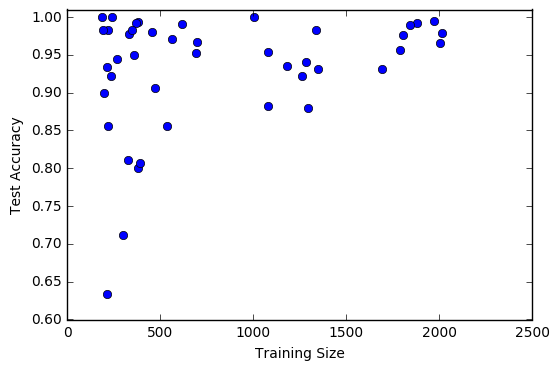

In [36]:
plt.plot(np.bincount(y_train), cls_accuracy, 'bo')
plt.ylim(ymax=1.01)
plt.xlabel("Training Size")
plt.ylabel("Test Accuracy")

### Observation
From the above plot we see that
- Accuracy is good when more than 1000 training data 
- Accuracy varies a lot when training data is less than 500

We will next try augmenting the training data

In [43]:
def transform_image(img):
    # rotation
    angle_range = 20
    rot_angel = np.random.uniform(angle_range) - angle_range / 2
    h, w, _ = img.shape
    rot_m = cv2.getRotationMatrix2D((w / 2, h / 2), rot_angel, 1)
    img1 = cv2.warpAffine(img, rot_m, (w, h))
    
    # Translation
    trans_range = 10
    tr_x = trans_range * np.random.uniform() - trans_range / 2
    tr_y = trans_range * np.random.uniform() - trans_range / 2
    Trans_M = np.float32([[1,0,tr_x], [0,1,tr_y]])
    img1 = cv2.warpAffine(img1, rot_m, (w, h))
        
    # brigthness change
    random_bright = 0.5 + np.random.uniform()
    img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2HSV)
    img1[:,:,2] = img[:,:,2] * random_bright
    img1 = cv2.cvtColor(img1, cv2.COLOR_HSV2RGB)

    return img1

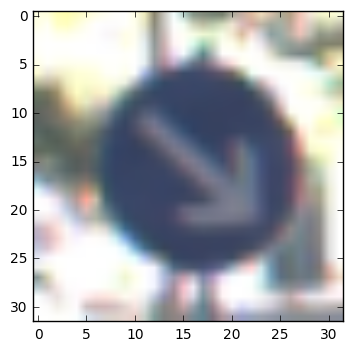

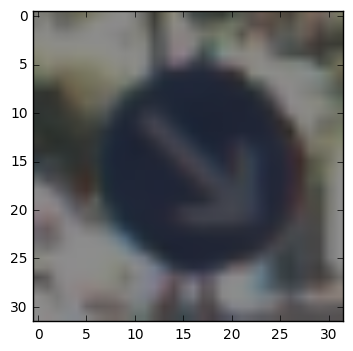

In [48]:
# Test the transformation
rand_idx = np.random.randint(X_train.shape[0])
X_prime = X_train[rand_idx: rand_idx + 1,]
for img in X_prime:
    t_img = transform_image(img)
    plt.imshow(img)
    plt.show()
    plt.imshow(t_img)
    plt.show()

In [49]:
# Include 2x more training data
tr_set1 = np.asarray([transform_image(img) for img in X_train])
tr_set2 = np.asarray([transform_image(img) for img in X_train])
X_train_new = np.vstack((tr_set1, tr_set2, X_train))
y_train_new = np.hstack((y_train, y_train, y_train))
print(X_train_new.shape, y_train_new.shape)

(105864, 32, 32, 3) (105864,)


In [53]:
summary_dir, checkpoint_dir, checkpoint_prefix = create_outdirs("more_data")
train(X_train_new, y_train_new, summary_dir, checkpoint_prefix)

Output directory runs/more_data
Training for 105864
EPOCH 1 Learning Rate=0.00098 Validation Accuracy = 0.712
EPOCH 2 Learning Rate=0.00097 Validation Accuracy = 0.900
EPOCH 3 Learning Rate=0.00095 Validation Accuracy = 0.939
EPOCH 4 Learning Rate=0.00093 Validation Accuracy = 0.958
EPOCH 5 Learning Rate=0.00092 Validation Accuracy = 0.966
EPOCH 6 Learning Rate=0.00090 Validation Accuracy = 0.969
EPOCH 7 Learning Rate=0.00089 Validation Accuracy = 0.975
EPOCH 8 Learning Rate=0.00087 Validation Accuracy = 0.978
EPOCH 9 Learning Rate=0.00085 Validation Accuracy = 0.979
EPOCH 10 Learning Rate=0.00084 Validation Accuracy = 0.977
EPOCH 11 Learning Rate=0.00083 Validation Accuracy = 0.982
EPOCH 12 Learning Rate=0.00081 Validation Accuracy = 0.985
EPOCH 13 Learning Rate=0.00080 Validation Accuracy = 0.983
EPOCH 14 Learning Rate=0.00078 Validation Accuracy = 0.985
EPOCH 15 Learning Rate=0.00077 Validation Accuracy = 0.987
EPOCH 16 Learning Rate=0.00076 Validation Accuracy = 0.981
EPOCH 17 Lear

In [54]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir))    
    test_accuracy = evaluate(X_test, y_test)
    corrects = sess.run(correct_prediction, 
                        feed_dict={x:X_test, y:y_test, keep_prob:1.0})

    print("Test Accuracy = {:.3f}".format(test_accuracy))

new_cls_accuracy = np.bincount(y_test[corrects]) / np.bincount(y_test)

Test Accuracy = 0.954


In [63]:
# Check the difference in accuracy for each class
diff = new_cls_accuracy - cls_accuracy
print("Improved Accuracy in %d class out of Total %d classes" % (
    (diff >0).sum(), len(diff)))

Improved Accuracy in 25 class out of Total 43 classes


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

**Progress Chart**


Date | Model Type | Improvements | Validation Accuracy | Test Accuracy
---|---|---|---|---
2017-01-05 | LeNet-5 | First Version | 0.982 | 0.920
2017-01-06 | LeNet-5 | Mean Image Subtraction | 0.989 | 0.933
2017-01-09 | LeNet-5 | 110 Epoch with learning rate decay <br> = 0.001 * 0.9 ^ (global_step / 5000) | 0.990 | 0.941
2017-01-09 | LeNet-5 | 120 Epoch + Dropout with keep_prob = 0.75 | 0.993 | 0.949
2017-01-17 | LeNet-5 | 120 Epoch + Image Augmentation | 0.992 | 0.954

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [66]:
values, indices = tf.nn.top_k(tf.nn.softmax(logits), k=3)

def predict_top_k(img, label_signs):
    sess = tf.get_default_session()
    vals, idxs = sess.run([values, indices], 
                          feed_dict={x : img[None, ], keep_prob: 1.0})
    
    vals = vals[0]
    idxs = idxs[0]
    top_k = ["{}\t{:.3f}".format(label_signs[idxs[i]], vals[i]) for i in range(len(vals))]
    return top_k

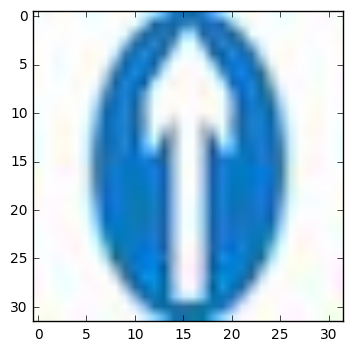

move_ahead.jpg
Ahead only	1.000
Go straight or right	0.000
Speed limit (20km/h)	0.000


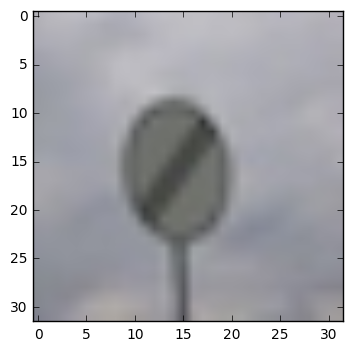

end_of_speed_limit_and_passing.jpg
Priority road	0.777
Yield	0.200
Ahead only	0.014


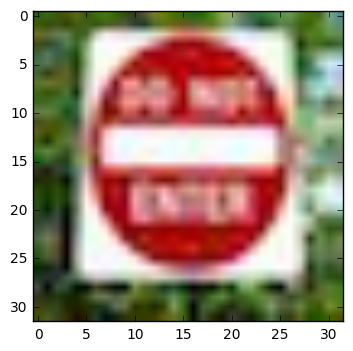

traffic-signs-philadelphia-camden.jpg
No passing	0.993
No entry	0.007
Vehicles over 3.5 metric tons prohibited	0.000


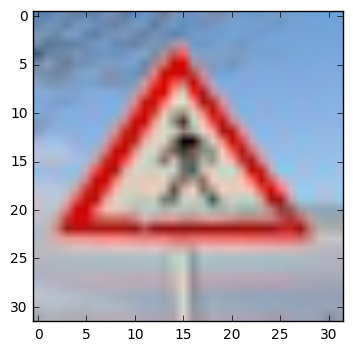

children_cross.jpg
Children crossing	0.730
General caution	0.264
Bicycles crossing	0.006


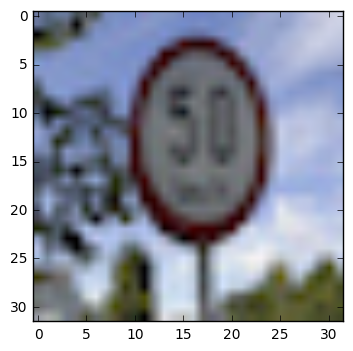

50KM.jpg
Priority road	0.997
Yield	0.003
No vehicles	0.000


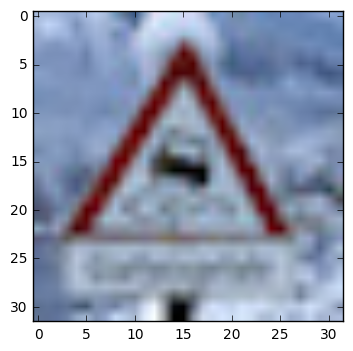

slippery-road.jpg
Slippery road	1.000
Beware of ice/snow	0.000
Dangerous curve to the left	0.000


In [79]:
import matplotlib.image as mpimg

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir))
    
    for image_file in os.listdir("test_images"):
        img = mpimg.imread(os.path.join("test_images", image_file))
        plt.imshow(img)
        plt.show()

        top_k = predict_top_k(img, label_signs)
        print(image_file)
        for p in top_k:
            print(p)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
# Above we have shown the images and the predictions

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

#### Top 3 predictions are shown along with the images above
#### It is accurate for 50% of the images (3 out of 6)

#### When the image has lot of background (in case of 50km/h) or blurry (in case of do not enter) then it is failing

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

In [81]:
# top 3 softmax probablities are shown along with the images above

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.